In [20]:
from matplotlib import pyplot as plt
import turbine_data as turbine
import xfoil_scripts as xfoil
import numpy as np
import os
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams["axes.grid"]=True
import timeit
import pickle


### Retrieve and plot some airfoil shapes

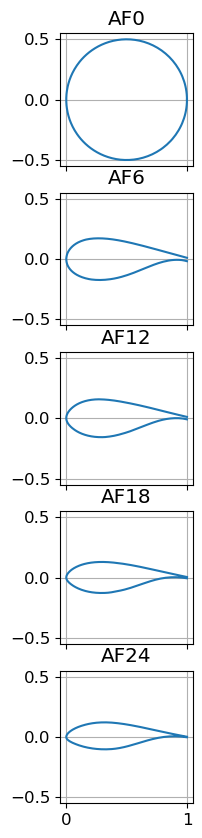

In [21]:
N = 5
plt.rcParams['figure.figsize'] = [20,2*N]
fig, axs = plt.subplots(N,1,sharex=True,sharey=True)
for i in range(N):
    x,y = turbine.get_xy_from_file(i*(30//(N)))
    axs[i].plot(x,y)
    axs[i].set_aspect("equal")
    axs[i].set_title("AF"+str(i*(30//(N))))

### As scatter plot, with camber line

Surface point variables: 400


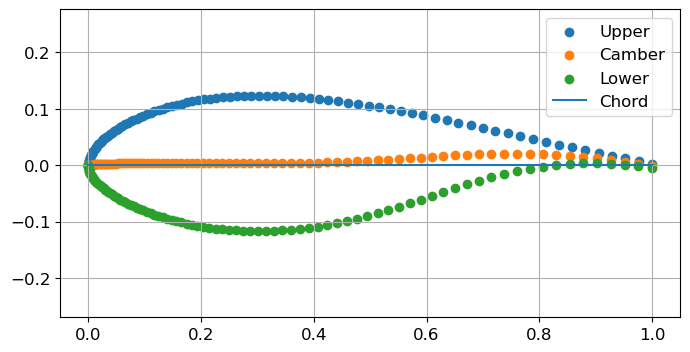

In [22]:
airfoil = 20
resolution = 1

plt.rcParams['figure.figsize'] = [8,4]
upper,camber,lower = turbine.get_reduced_resolution_shape(airfoil,resolution,method="divided")
plt.scatter(upper[0],upper[1])
plt.scatter(camber[0],camber[1])
plt.scatter(lower[0],lower[1])
plt.plot([0,1],[0,0])
plt.legend(["Upper","Camber","Lower","Chord"])
plt.axis("equal")
print("Surface point variables:",int(100*resolution*4))

### Reduced resolution shape used to reduce network complexity

Surface point variables: 40


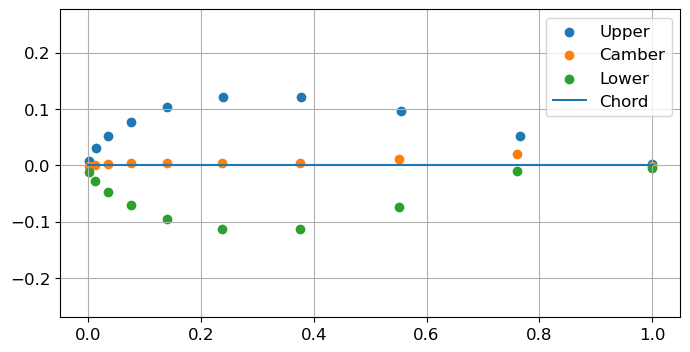

In [23]:
airfoil = 20
resolution = 0.1

plt.rcParams['figure.figsize'] = [8,4]
upper,camber,lower = turbine.get_reduced_resolution_shape(airfoil,resolution,method="divided")
plt.scatter(upper[0],upper[1])
plt.scatter(camber[0],camber[1])
plt.scatter(lower[0],lower[1])
plt.plot([0,1],[0,0])
plt.legend(["Upper","Camber","Lower","Chord"])
plt.axis("equal")
print("Surface point variables:",int(100*resolution*4))

### Blade geometry Info

Text(0.5, 0, 'Distance on blade [m]')

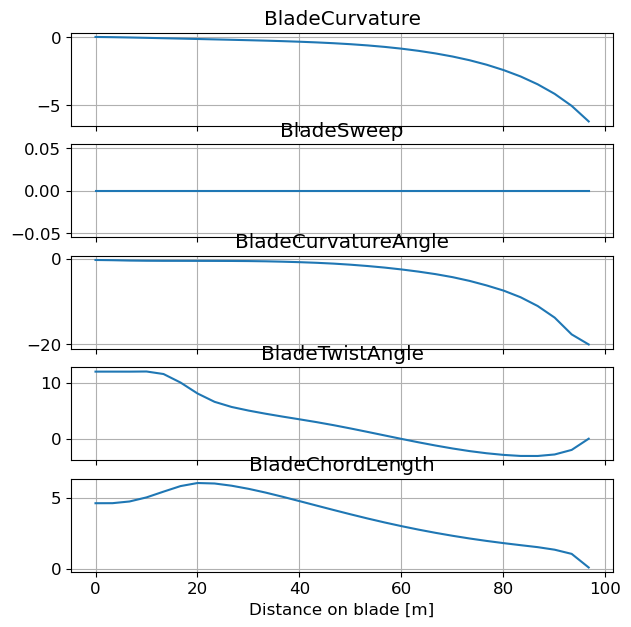

In [24]:
plt.rcParams['figure.figsize'] = [7,7]
data = turbine.get_blade_data()
fig,ax = plt.subplots(5,1,sharex=True)
keys = list(data.keys())
for v in range(5):
    ax[v].plot(data[keys[0]],data[keys[v+1]])
    ax[v].set_title(keys[v+1])
ax[-1].set_xlabel("Distance on blade [m]")

### Retrieve and plot airfoil aerodynamic coefficient data

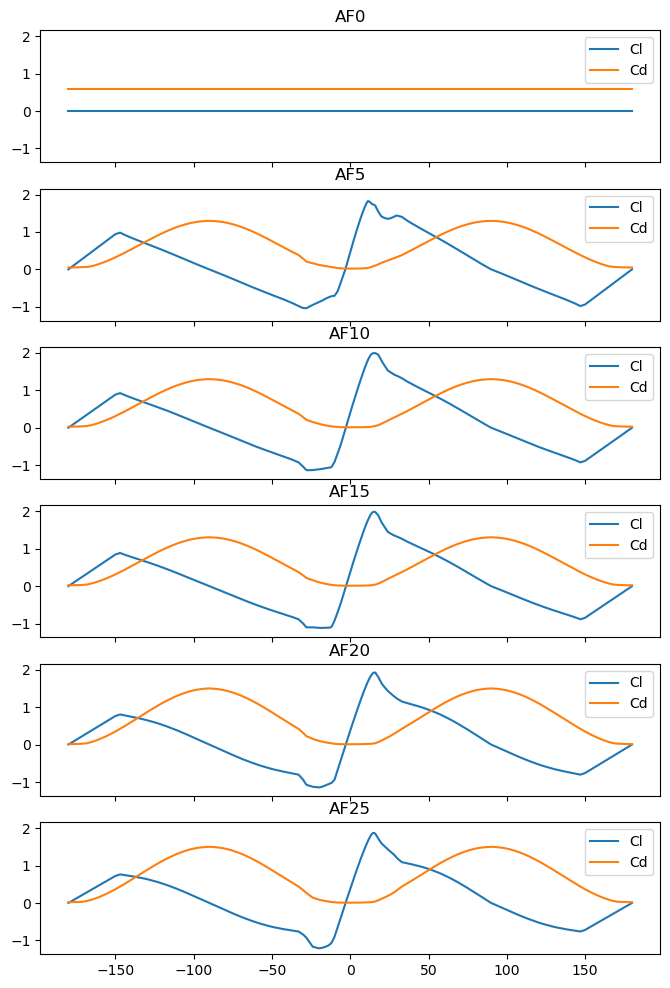

In [6]:
N = 6
plt.rcParams['figure.figsize'] = [8,2*N]
fig, axs = plt.subplots(N,sharex=True,sharey=True)
for i in range(N):
    alpha, Cl, Cd, _ = turbine.get_ClCd_from_file((30//N)*i)
    ax = axs[i]
    ax.plot(alpha,Cl)
    ax.plot(alpha,Cd)
    ax.set_title("AF"+str((30//N)*i))
    ax.legend(["Cl","Cd"])

### Xfoil plots

In [7]:
import xfoil_scripts as xfoil
from tqdm import tqdm
import os
import sys
import time
import signal
import subprocess
import pandas as pd
alpha, Cl, Cd, _ = turbine.get_ClCd_from_file(20)
os.system("taskkill /im xfoil.exe /F")

128

In [8]:
airfoil = 25

xfoil_Cl = np.zeros_like(alpha)
xfoil_Cd = np.zeros_like(alpha)
error = np.ones_like(alpha)
nonconvergence = 0
for a in (pbar:=tqdm(range(len(alpha)))):
    if (alpha[a]>=-30) and (alpha[a]<=30) and (a%1==0):
        try:
            res = xfoil.run_xfoil(alpha=alpha[a],iter=500,timeout=2,airfoil=airfoil)
            xfoil_Cl[a] = res["CL"][0]
            xfoil_Cd[a] = res["CD"][0]
            error[a] = 0
            pbar.set_description("Alpha {}, Cl {}, Cd {}".format(alpha[a],res["CL"][0],res["CD"][0]))
        except TimeoutError:
            pbar.set_description("Alpha {}: Timeout error.".format(alpha[a]))
        except ValueError:
            pbar.set_description("Alpha {}: Convergence error.".format(alpha[a]))
            nonconvergence += 1
print("Non-convering values:",sum(error))

  0%|          | 0/200 [00:00<?, ?it/s]

Alpha 30.0, Cl 1.6576, Cd 0.26311: 100%|██████████| 200/200 [01:26<00:00,  2.32it/s]              

Non-convering values: 103.0


Text(0.5, 1.0, 'Values of alpha for which xofil does not converge')

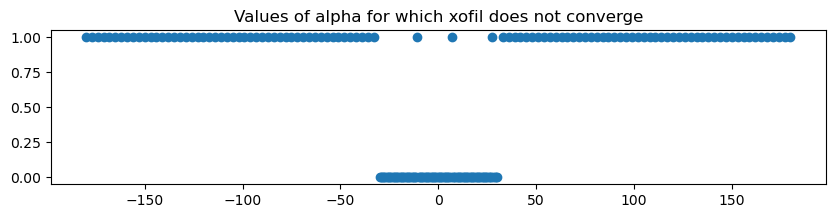

In [9]:
plt.rcParams['figure.figsize'] = [10,2]
plt.scatter(alpha,error)
plt.title("Values of alpha for which xofil does not converge")

In [18]:
plt.rcParams['figure.figsize'] = [6,3]
plt.plot(alpha[xfoil_Cl!=0],Cl[xfoil_Cl!=0])
plt.plot(alpha[xfoil_Cl!=0],xfoil_Cl[xfoil_Cl!=0])
plt.legend(["True_Cl","Xfoil_Cl"])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 25

In [11]:
N = 25
Re = np.logspace(6,9,N,dtype=int)

os.system("taskkill /im xfoil.exe /F")
xfoil_Cl = np.zeros(N)
xfoil_Cd = np.zeros(N)
for r in (pbar:=tqdm(range(len(Re)))):
    try:
        res = xfoil.run_xfoil(Re=Re[r],timeout=2)
        xfoil_Cl[r] = res["CL"][0]
        xfoil_Cd[r] = res["CD"][0]
        pbar.set_description("Re {}, Cl {}, Cd {}".format(Re[r],res["CL"][0],res["CD"][0]))
    except TimeoutError:
        pbar.set_description("Timeout error.")
    except ValueError:
        pbar.set_description("No convergence")

Re 1000000000, Cl 1.0545, Cd 0.00633: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


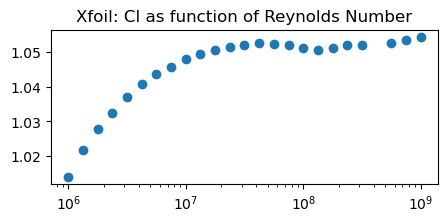

In [12]:
plt.rcParams['figure.figsize'] = [5,2]
plt.scatter(Re[xfoil_Cl>0.1],xfoil_Cl[xfoil_Cl>0.1])
plt.title("Xfoil: Cl as function of Reynolds Number")
plt.gca().set_xscale("log")

In [13]:
N = 25
Mach = np.linspace(0,0.7,N)

os.system("taskkill /im xfoil.exe /F")
xfoil_Cl = np.zeros(N)
xfoil_Cd = np.zeros(N)
for m in (pbar:=tqdm(range(N))):
    try:
        res = xfoil.run_xfoil(Mach=Mach[m],timeout=2)
        xfoil_Cl[m] = res["CL"][0]
        xfoil_Cd[m] = res["CD"][0]
        pbar.set_description("Mach {}, Cl {}, Cd {}".format(Mach[m].__round__(2),res["CL"][0],res["CD"][0]))
    except TimeoutError:
        pbar.set_description("Mach {}: Timeout error.".format(Mach[m].__round__(2)))
    except ValueError:
        pbar.set_description("Mach {}: No convergence.".format(Mach[m].__round__(2)))
    except FileNotFoundError:
        pbar.set_description("Mach {}: No output file.".format(Mach[m].__round__(2)))

Mach 0.7: Timeout error.: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]        


Text(0.5, 1.0, 'Xfoil: Cl as function of Mach number')

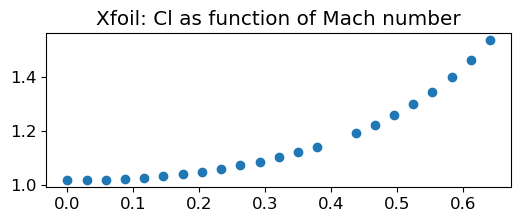

In [14]:
plt.rcParams['figure.figsize'] = [6,2]
plt.rcParams['font.size'] = 12
plt.scatter(Mach[xfoil_Cl>0.1],xfoil_Cl[xfoil_Cl>0.1])
plt.title("Xfoil: Cl as function of Mach number")

# Xfoil vs IEA

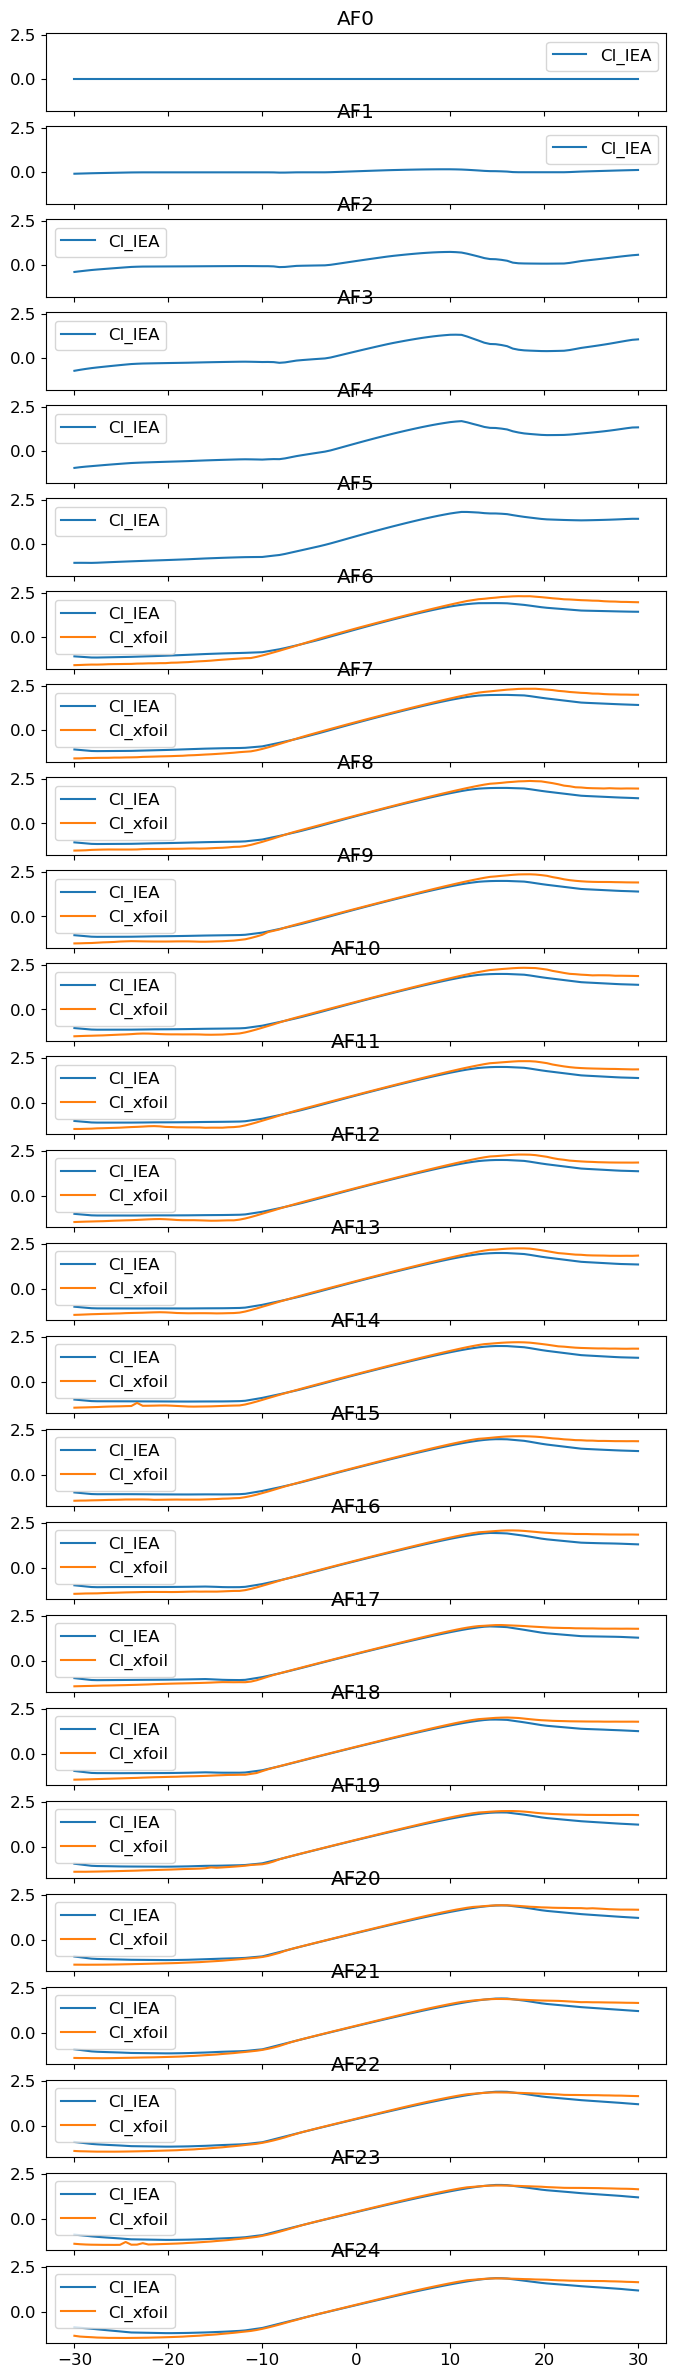

In [19]:
(s,e) = 50,150

plt.rcParams['figure.figsize'] = [8,30]
fig, axs = plt.subplots(N,sharex=True,sharey=True)
with open("dataset/dataset.pickle","rb") as f:
    data = pickle.load(f)
for i in range(N):
    alpha, Cl, Cd, _ = turbine.get_ClCd_from_file((30//N)*i)
    ax = axs[i]
    ax.plot(alpha[s:e],[data[i,'Target',a,"Cl"] for a in alpha[s:e]])
    if i>5:
        ax.plot(alpha[np.max((s,50)):np.min((e,150))],[data[i,'xfoil',a,'Cl'][0] for a in alpha[np.max((s,50)):np.min((e,150))]])
#    ax.plot(alpha,Cl)
#    ax.plot(alpha,Cd)
    ax.set_title("AF"+str((30//N)*i))
    ax.legend(["Cl_IEA","Cl_xfoil"])